### Importing Necessary Libraries and data

In [69]:
import sklearn
print(sklearn.__version__)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

1.7.2


In [70]:
file_path = 'train.csv'

train_df = pd.read_csv(file_path)

train_df.head(5)

id road_type  num_lanes  curvature  speed_limit  lighting weather  \
0   0     urban          2       0.06           35  daylight   rainy   
1   1     urban          4       0.99           35  daylight   clear   
2   2     rural          4       0.63           70       dim   clear   
3   3   highway          4       0.07           35       dim   rainy   
4   4     rural          1       0.58           60  daylight   foggy   

   road_signs_present  public_road time_of_day  holiday  school_season  \
0               False         True   afternoon    False           True   
1                True        False     evening     True           True   
2               False         True     morning     True          False   
3                True         True     morning    False          False   
4               False        False     evening     True          False   

   num_reported_accidents  accident_risk  
0                       1           0.13  
1                       0           0.35  
2                       2           0.30  
3                       1           0.21  
4                       1           0.56

### Data Cleaning and EDA

In [71]:
train_df.shape

(517754, 14)

In [72]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

In [73]:
train_df.isnull().sum()

id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64

In [74]:
train_df.duplicated().sum()

0

### Feature Engineering

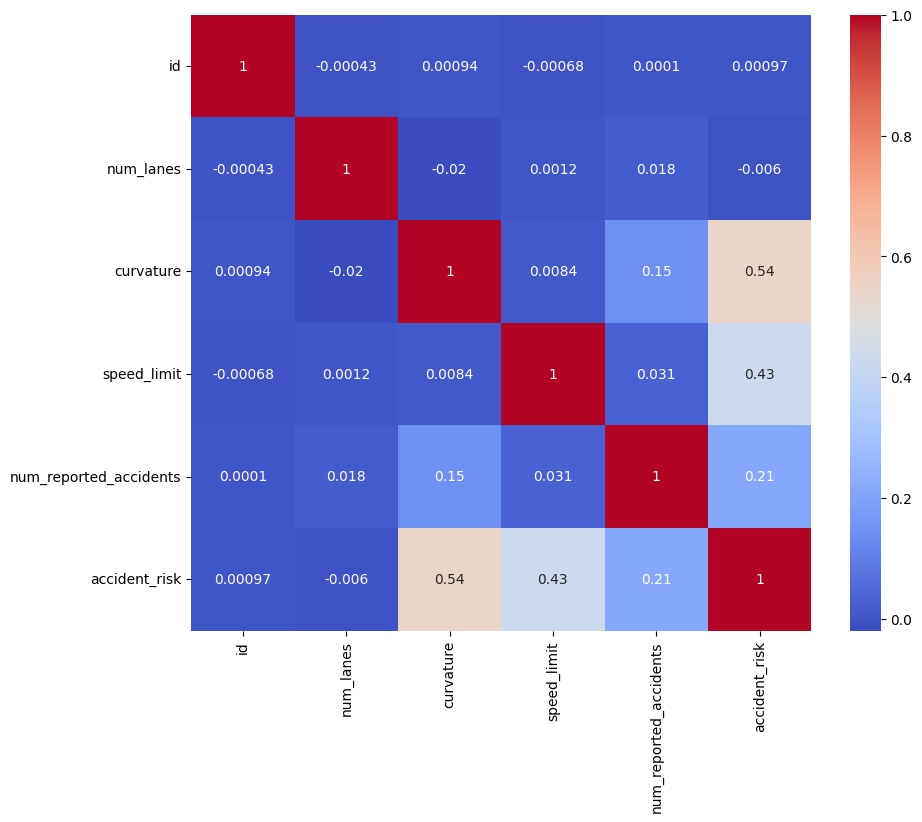

In [75]:
columns = [col for col in train_df.columns if train_df[col].dtype != 'object' and train_df[col].dtype != 'bool']
num_train_df = train_df[columns]
plt.figure(figsize=(10, 8))
sns.heatmap(num_train_df.corr(), annot=True, cmap='coolwarm')
plt.show()

A less correlation can be seen among various variables hence no multicollinearity is present in the data



## Conclusion of EDA and Data Cleaning:
* Since Data does not contain any nan values hence no need to drop na
* Also the data is free from multicollinearity and there is no feature that can be dropped as all features seems equaly important
* Hence the data will be taken as it is

### Train Test Split

In [76]:
train_df_copy = train_df.copy()

In [77]:
X = train_df_copy.drop('accident_risk', axis=1)
y = train_df_copy['accident_risk']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((414203, 13), (103551, 13), (414203,), (103551,))

### Applying Ordinal Encoding

In [78]:
num_columns = [col for col in train_df.columns if train_df[col].dtype != 'object' and train_df[col].dtype != 'bool' and col!='accident_risk' and col!='id']
non_num_colums = [col for col in train_df.columns if (train_df[col].dtype == 'object' or train_df[col].dtype == 'bool') and col != 'accident_risk']

In [79]:
x = {}
for col in non_num_colums:
  x[col] = train_df_copy[col].nunique()

print(x)

{'road_type': 3, 'lighting': 3, 'weather': 3, 'road_signs_present': 2, 'public_road': 2, 'time_of_day': 3, 'holiday': 2, 'school_season': 2}


In [80]:
oe = OrdinalEncoder()

X_train_encoded = oe.fit_transform(X_train[non_num_colums])
X_test_encoded = oe.transform(X_test[non_num_colums])

X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=non_num_colums)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=non_num_colums)

X_train_final = pd.concat([X_train[num_columns].reset_index(drop=True), X_train_encoded_df.reset_index(drop=True)],axis=1)
X_test_final = pd.concat([X_test[num_columns].reset_index(drop=True), X_test_encoded_df.reset_index(drop=True)],axis=1)

In [81]:
X_train_final

num_lanes  curvature  speed_limit  num_reported_accidents  road_type  \
0               2       0.43           60                       2        1.0   
1               4       0.18           25                       1        0.0   
2               1       0.20           70                       1        2.0   
3               3       0.81           60                       1        2.0   
4               3       0.43           35                       2        1.0   
...           ...        ...          ...                     ...        ...   
414198          4       0.05           60                       1        1.0   
414199          3       0.47           70                       1        1.0   
414200          3       0.51           70                       2        0.0   
414201          3       0.91           60                       4        1.0   
414202          3       0.78           60                       0        1.0   

        lighting  weather  road_signs_present  public_road  time_of_day  \
0            1.0      0.0                 0.0          0.0          0.0   
1            2.0      0.0                 0.0          0.0          0.0   
2            2.0      0.0                 0.0          1.0          2.0   
3            0.0      1.0                 1.0          0.0          1.0   
4            2.0      2.0                 0.0          1.0          2.0   
...          ...      ...                 ...          ...          ...   
414198       1.0      0.0                 0.0          1.0          2.0   
414199       1.0      2.0                 0.0          0.0          1.0   
414200       2.0      0.0                 1.0          1.0          0.0   
414201       2.0      2.0                 1.0          0.0          1.0   
414202       0.0      0.0                 0.0          0.0          1.0   

        holiday  school_season  
0           1.0            1.0  
1           1.0            0.0  
2           1.0            1.0  
3           1.0            1.0  
4           1.0            1.0  
...         ...            ...  
414198      1.0            0.0  
414199      1.0            1.0  
414200      0.0            1.0  
414201      0.0            0.0  
414202      0.0            0.0  

[414203 rows x 12 columns]

In [82]:
X_test_final

num_lanes  curvature  speed_limit  num_reported_accidents  road_type  \
0               1       0.09           45                       2        0.0   
1               4       0.14           60                       0        2.0   
2               2       0.51           25                       0        0.0   
3               1       0.33           60                       1        1.0   
4               4       0.12           60                       1        2.0   
...           ...        ...          ...                     ...        ...   
103546          2       0.19           25                       0        2.0   
103547          3       0.63           45                       0        1.0   
103548          2       0.68           45                       1        0.0   
103549          3       0.43           25                       2        0.0   
103550          2       0.16           45                       2        0.0   

        lighting  weather  road_signs_present  public_road  time_of_day  \
0            1.0      2.0                 0.0          0.0          0.0   
1            0.0      2.0                 0.0          1.0          2.0   
2            1.0      2.0                 1.0          1.0          1.0   
3            0.0      0.0                 0.0          1.0          2.0   
4            0.0      1.0                 0.0          1.0          0.0   
...          ...      ...                 ...          ...          ...   
103546       1.0      0.0                 0.0          0.0          1.0   
103547       1.0      0.0                 1.0          0.0          1.0   
103548       2.0      0.0                 0.0          1.0          2.0   
103549       1.0      0.0                 0.0          0.0          0.0   
103550       0.0      1.0                 1.0          1.0          1.0   

        holiday  school_season  
0           1.0            0.0  
1           1.0            0.0  
2           0.0            0.0  
3           0.0            1.0  
4           0.0            0.0  
...         ...            ...  
103546      0.0            0.0  
103547      1.0            1.0  
103548      1.0            0.0  
103549      0.0            0.0  
103550      0.0            0.0  

[103551 rows x 12 columns]

### Training XGBoost and other ML models

In [83]:
!pip install xgboost

In [84]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

models = { "XGBoost": XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        tree_method="hist",
        random_state=42
    )}

results = []

for name, model in models.items():
    print(f"\nüöÄ Training {name} ...")
    try:
        model.fit(X_train_final, y_train)
        y_pred = model.predict(X_test_final)

        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        results.append({
            "Model": name,
            "R2 Score": round(r2, 4),
            "MAE": round(mae, 4),
            "RMSE": round(rmse, 4)
        })
    except Exception as e:
        print(f"‚ö†Ô∏è Skipping {name} due to error: {e}")


üöÄ Training XGBoost ...


In [85]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5),
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42)
    }

for name, model in models.items():
    print(f"\nüöÄ Training {name} ...")
    try:
        model.fit(X_train_final, y_train)
        y_pred = model.predict(X_test_final)

        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        results.append({
            "Model": name,
            "R2 Score": round(r2, 4),
            "MAE": round(mae, 4),
            "RMSE": round(rmse, 4)
        })
    except Exception as e:
        print(f"‚ö†Ô∏è Skipping {name} due to error: {e}")

results_df = pd.DataFrame(results).sort_values(by="RMSE", ascending=True)
print(results_df.reset_index(drop=True))


üöÄ Training Linear Regression ...

üöÄ Training Ridge ...

üöÄ Training Lasso ...

üöÄ Training ElasticNet ...

üöÄ Training Decision Tree ...
               Model  R2 Score     MAE    RMSE
0            XGBoost    0.8853  0.0437  0.0563
1      Decision Tree    0.8841  0.0438  0.0566
2  Linear Regression    0.7167  0.0708  0.0884
3              Ridge    0.7167  0.0708  0.0884
4              Lasso    0.7161  0.0708  0.0885
5         ElasticNet    0.7165  0.0708  0.0885


In [86]:
X_train_final

num_lanes  curvature  speed_limit  num_reported_accidents  road_type  \
0               2       0.43           60                       2        1.0   
1               4       0.18           25                       1        0.0   
2               1       0.20           70                       1        2.0   
3               3       0.81           60                       1        2.0   
4               3       0.43           35                       2        1.0   
...           ...        ...          ...                     ...        ...   
414198          4       0.05           60                       1        1.0   
414199          3       0.47           70                       1        1.0   
414200          3       0.51           70                       2        0.0   
414201          3       0.91           60                       4        1.0   
414202          3       0.78           60                       0        1.0   

        lighting  weather  road_signs_present  public_road  time_of_day  \
0            1.0      0.0                 0.0          0.0          0.0   
1            2.0      0.0                 0.0          0.0          0.0   
2            2.0      0.0                 0.0          1.0          2.0   
3            0.0      1.0                 1.0          0.0          1.0   
4            2.0      2.0                 0.0          1.0          2.0   
...          ...      ...                 ...          ...          ...   
414198       1.0      0.0                 0.0          1.0          2.0   
414199       1.0      2.0                 0.0          0.0          1.0   
414200       2.0      0.0                 1.0          1.0          0.0   
414201       2.0      2.0                 1.0          0.0          1.0   
414202       0.0      0.0                 0.0          0.0          1.0   

        holiday  school_season  
0           1.0            1.0  
1           1.0            0.0  
2           1.0            1.0  
3           1.0            1.0  
4           1.0            1.0  
...         ...            ...  
414198      1.0            0.0  
414199      1.0            1.0  
414200      0.0            1.0  
414201      0.0            0.0  
414202      0.0            0.0  

[414203 rows x 12 columns]

In [87]:
results_df.drop_duplicates(inplace=True)
results_df = results_df.reset_index(drop=True)
results_df

Model  R2 Score     MAE    RMSE
0            XGBoost    0.8853  0.0437  0.0563
1      Decision Tree    0.8841  0.0438  0.0566
2  Linear Regression    0.7167  0.0708  0.0884
3              Ridge    0.7167  0.0708  0.0884
4              Lasso    0.7161  0.0708  0.0885
5         ElasticNet    0.7165  0.0708  0.0885

### Conclusion for ML Models:

Gradient Boosting and XG Boost both perform best in terms of RMSE. However R2 Score needs to be improved

### Creating Pipeline and Deploying it in Pickle using XG Boost as our model

In [88]:
xgb = XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        n_jobs=-1,
        tree_method="hist",
        random_state=42)

In [89]:
len(num_columns)+len(non_num_colums)

12

In [90]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_columns),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), non_num_colums)
    ],
    remainder='drop'  # drop anything not listed above
)

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb)
])

In [91]:
X_train.drop("id",axis=1,inplace=True)
X_test.drop("id",axis=1,inplace=True)

In [92]:
pipe.fit(X_train, y_train)

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\nehap\\Downloads\\ANN Classification\\venv\\Lib\\site-packages\\sklearn\\utils\\_repr_html\\estimator.js'

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\nehap\\Downloads\\ANN Classification\\venv\\Lib\\site-packages\\sklearn\\utils\\_repr_html\\estimator.js'

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['num_lanes', 'curvature',
                                                   'speed_limit',
                                                   'num_reported_accidents']),
                                                 ('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['road_type', 'lighting',
                                                   'weather',
                                                   'road_signs_present',
                                                   'public_road', 'time_of_day',
                                                   'holiday',
                                                   'school_season'])])),
    

In [93]:
test_df = pd.read_csv('test.csv')

pipe.predict(test_df)

array([0.2916472 , 0.12454035, 0.18568146, ..., 0.2510809 , 0.1281955 ,
       0.48758245], dtype=float32)

### Predicting Test Values and Creating my_submission.csv file

In [94]:
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'accident_risk': pipe.predict(test_df)
})

submission_df

id  accident_risk
0       517754       0.291647
1       517755       0.124540
2       517756       0.185681
3       517757       0.328850
4       517758       0.402150
...        ...            ...
172580  690334       0.111212
172581  690335       0.518525
172582  690336       0.251081
172583  690337       0.128195
172584  690338       0.487582

[172585 rows x 2 columns]